<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных-(EDA)" data-toc-modified-id="Исследовательский-анализ-данных-(EDA)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных (EDA)</a></span></li><li><span><a href="#Модель-прогнозирования-оттока-клиентов" data-toc-modified-id="Модель-прогнозирования-оттока-клиентов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель прогнозирования оттока клиентов</a></span></li><li><span><a href="#Кластеризация-клиентов" data-toc-modified-id="Кластеризация-клиентов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Кластеризация клиентов</a></span></li><li><span><a href="#Выводы-и-рекомендации" data-toc-modified-id="Выводы-и-рекомендации-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы и рекомендации</a></span></li></ul></div>

# Прогнозирование вероятности оттока клиентов фитнес-центра


Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Изучим эти данные и попробуем разработать модель, которая сможет предсказывать факт оттока для каждого клиента, и на основании этого предлагать ему более выгодные условия, которые "удержат" его в фитнес-клубе.

## Цели и задачи

<b> Цель проекта:</b> научиться выявлять клиентов, склонных к оттоку, и своевременно предпринимать меры, направленные на предотвращение оттока.

<b> Задачи:</b>

    1. Проанализировать имеющиеся данные
    2. На основе имеющихся данных создать обученную модель, способную прогнозировать склонность клиентов к оттоку
    3. Разработать стратегию по удержанию клиентов

## Описание данных

Согласно описанию, мы имеем следующие поля:

1. Данные клиента за предыдущий до проверки факта оттока месяц:
    - 'gender' — пол;
    - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
    -'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    - 'Phone' — наличие контактного телефона;
    - 'Age' — возраст;
    - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    - 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
    - 'Group_visits' — факт посещения групповых занятий;
    - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
    - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
    - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
3. 'Churn' — факт оттока в текущем месяце.

## Загрузка данных


Импортируем все необходимые библиотеки. Загрузим имеющийся файл и откроем его


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
import itertools

In [2]:
try:
    data = pd.read_csv('gym_churn.csv')
except FileNotFoundError:
    data = pd.read_csv('/datasets/gym_churn.csv')
    
    


In [3]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Итак, мы загрузили данные  и видим, что у нас есть информация о 4 тыс. клиентов. Явных пропусков в таблице нет. Все поля имеют числовой тип, при этом значения в некоторых из них - бинарные.

## Исследовательский анализ данных (EDA)

При вызове метода info() мы не обнаружили в датасете явных пропусков. Изучим средние значения и стандартные отклонения по столбцам при помощи метода describe().

In [5]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Изучать статистики для столбцов с бинарными значениями довольно бессмысленно, их следует анализировать иначе. Рассмотрим распределение значений в остальных полях. Для визуализации построим графики boxplot.

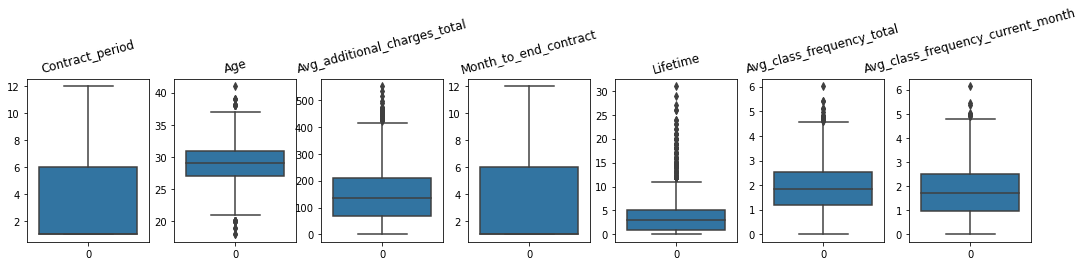

In [6]:
fig = plt.figure(figsize=(18, 3))

i = 0
for col in data.columns:
    if sorted(data[col].unique()) != [0, 1]:
        i+=1
        ax=fig.add_subplot(1,7,i)
        sns.boxplot(
                    data=data[col],
                    ax=ax
                   )
        ax.set_title(col, rotation = 15)
        

plt.show()
        

По полученным ящичкам с усами  мы можем сформулировать первые наблюдения:
1. Средний возраст посетителей фитнес-центра - 29 лет. Большинство клиентов - люди в возрасте от 21 до 37 лет. При этом половине из них - от 27 до 31 лет. 
2. На остальные услуги клиенты в среднем тратят 146 рублей. Большинство таких трат суммарно не превышают 400 рублей, более высокие суммы встречаются, но редко.
3. У 75% клиентов приобретены абонементы на срок 1 или 6 месяцев. Также у 75% клиентов до завершения абонемента остается от 1 до 6 месяцев.
4. Средний lifetime клиентов - 4 месяца.Клиенты, посещающие фитнес-центр больше года - единичные экземпляры. 
5. Графики средней частоты недельных посещений за прошлый месяц и весь период - очень похожи. В среднем люди ходят заниматься спортом 2 раза в неделю, однако встречаются уникумы, которые приходят и по 5-6 раз. Может они там работают?:)

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [7]:
data.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


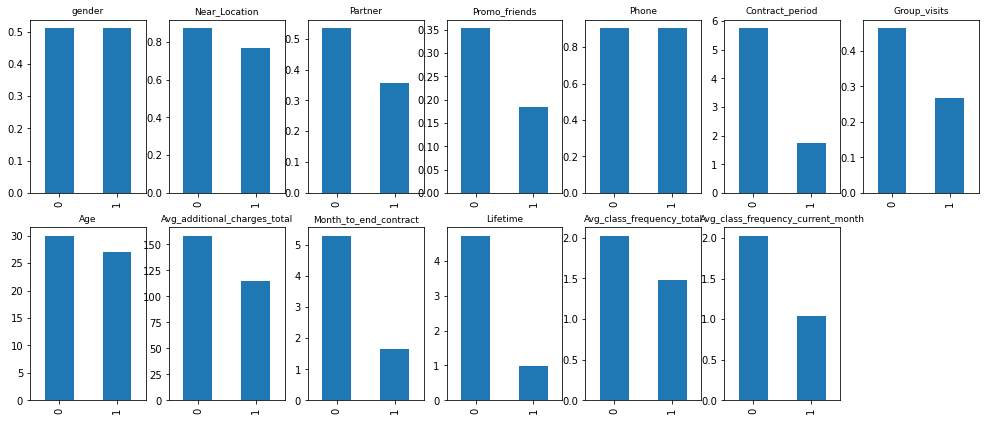

In [8]:
fig = plt.figure(figsize=(17, 7))
i = 0

for col in data.drop('Churn', axis=1).columns:
    i+=1
    ax=fig.add_subplot(2,7,i)
    data.groupby('Churn')[col].mean().plot(kind='bar')
    ax.set_xlabel(' ')
    ax.set_title(col, fontsize = 9)
        
plt.show()




Мы можем заметить, что практически для всех признаков средние значения "оттекающих" клиентов заметно ниже, чем для активных. У небинарных признаков эта разница выражена сильнее, у бинарных - слабее. Все логично - это связано с диапазоном значений. 

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

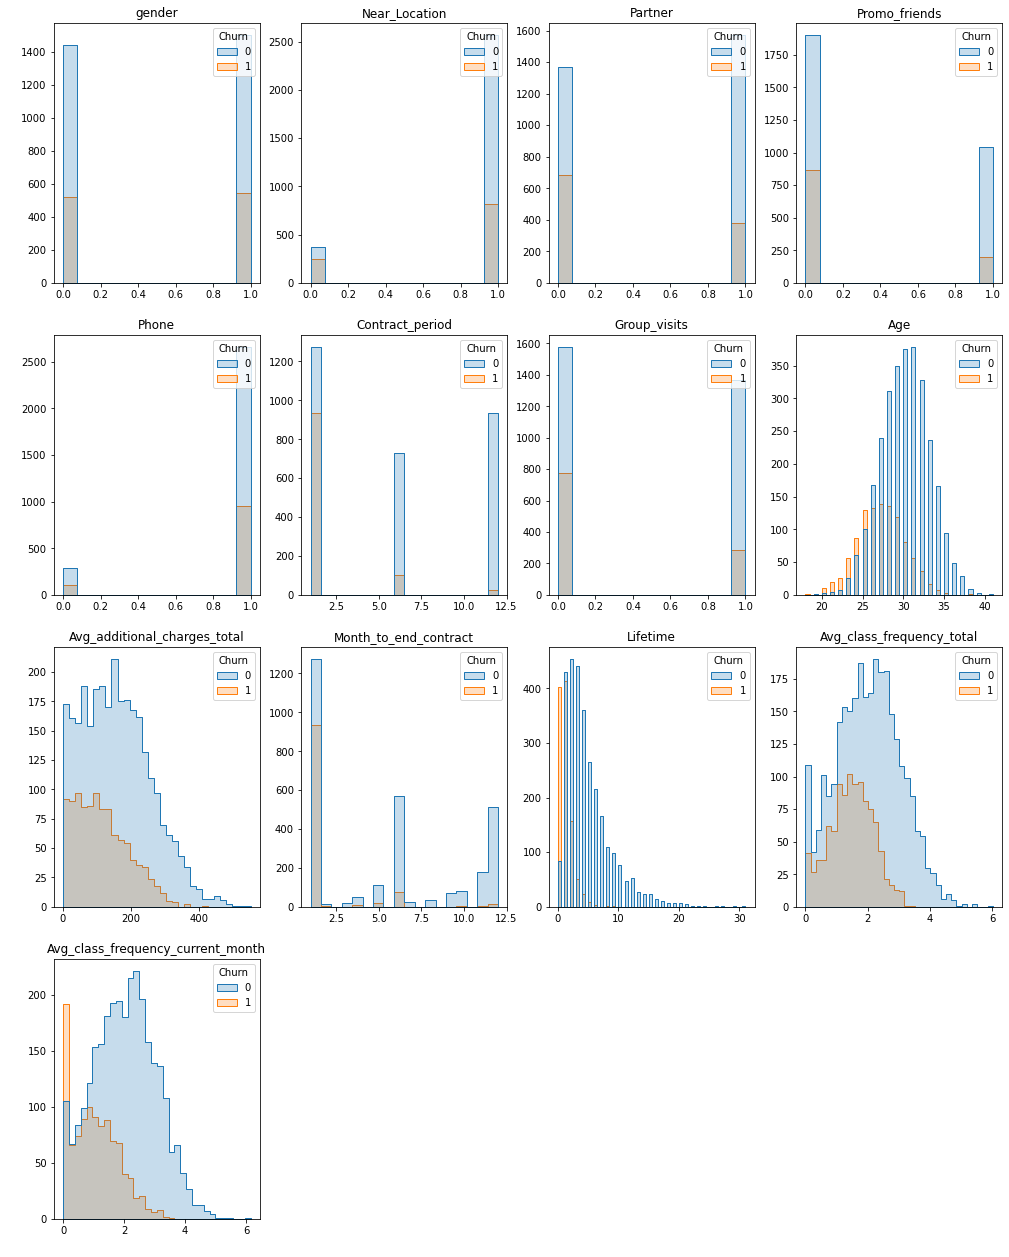

In [9]:
fig = plt.figure(figsize=(17, 22))
i = 0

for col in data.drop('Churn', axis=1).columns:
    i+=1
    ax=fig.add_subplot(4,4,i)
    sns.histplot(x=col, 
                 data=data, 
                 hue="Churn", 
                 element="step",
                 ax=ax
                 )
    ax.set_title(col)
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
      
plt.show()

Мы можем заметить, что оттекающих клиентов по всем признакам меньше, чем активных. Почти вовсех случаях синий график активных клиентов перекрывает оранжевый, для небинарных признаков колокол синего графика всегда шире - это означает, что клиенты не склонные к оттоку "выигривают" по всем признакам. Исключение составляют оранжевые выросы в районе 0 на графиках с недельной посещаемостью и lifetime - это те клиенты, которые начали ходить однажды и больше не вернулись. График распределения по возрасту чуть смещен - молодые люди оттекают чаще, чем старшие.



Теперь построим матрицу корреляций и отобразим её.

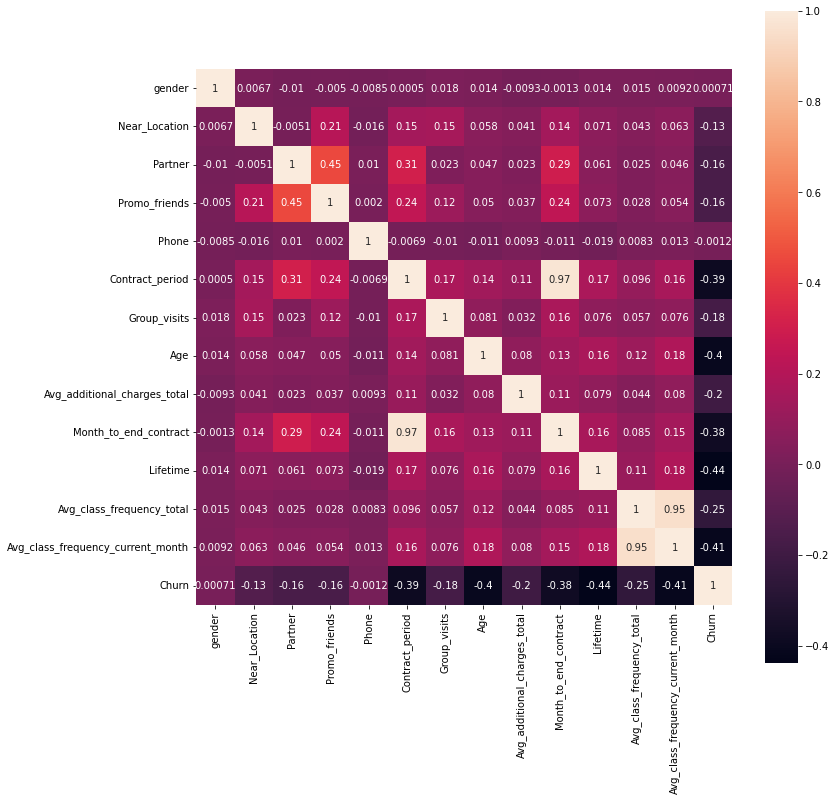

In [10]:
corr_m = data.corr()

plt.figure(figsize=(12,12))
sns.heatmap(corr_m,
           square = True, 
           annot = True
           )

plt.show()

По тепловой карте видны две пары сильно коррелирующих признаков: 

    - 'Contract_period' / 'Month_to_end_contract' 
    - 'Avg_class_frequency_total' / 'Avg_class_frequency_current_month
    
Чтобы избавиться от мультиколлинеарности, удалим из датафрейма по одному признаку из каждой пары. Оставим те, что больше коррелируют с целевой переменной.

In [11]:
data.drop(['Avg_class_frequency_total', 'Month_to_end_contract'], axis = 1, inplace = True) 

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Для начала разобьем данные на обучающую и валидационную выборку функцией train_test_split() и стандартизируем данные.

In [12]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(columns=['Churn'])
y = data['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
# стандартизируем данные 
scaler = StandardScaler()
scaler.fit(X_train)# обучите scaler на обучающей выборке методом fit
X_train_st = scaler.transform(X_train) # стандартизируем обучающую выборку методом transform scaler 
X_test_st = scaler.transform(X_test) # стандартизируем тестовую выборку методом transform scaler

Обучим модель на train-выборке логистической регрессией.


In [14]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0) 

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]


Теперь обучим модель на train-выборке случайным лесом.

In [15]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 

# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]


Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке и сравните по ним модели. Для удобства  реализуем функцию вывода метрик.

In [16]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))


In [17]:
# вызовем функцию два раза, чтобы вывести все метрики по обеим моделям
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82
Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.75


Доля правильных ответов одинаковая для обеих моделей, а вот точность и полнота, хоть и незначительно, отличаются - как мы знаем, оптимизация одной из этих метрик часто приводит к ухудшению другой. В данном случае это подтверждается.

По выбраннам метрикам модели выглядят одинаковыми. Сравним дополнительные метрики - F1-меру и площадь под кривой ошибок, чтобы принять решение.

In [18]:
def print_more_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [19]:
# вызовем функцию два раза, чтобы вывести все метрики по обеим моделям
print_more_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

print_more_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели логистической регрессии:
	F1: 0.81
	ROC_AUC: 0.96
Метрики для модели случайного леса:
	F1: 0.78
	ROC_AUC: 0.95


Итак, оценка метрик нам показывает, что модель логистической регрессии лучше - остановимся на ней.

## Кластеризация клиентов

Отложим в сторону столбец с оттоком и проведем кластеризацию клиентов. Сначала стандартизируем данные. На выходе получим преобразованные таблицы объект-признак для обучающего и валидационного набора. И уже их будем применять для обучения и прогнозирования.

In [20]:
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
x_sc = scaler.fit_transform(data.drop(columns = ['Churn'])) # обучаем нормализатор и преобразуем набор данных 

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. 

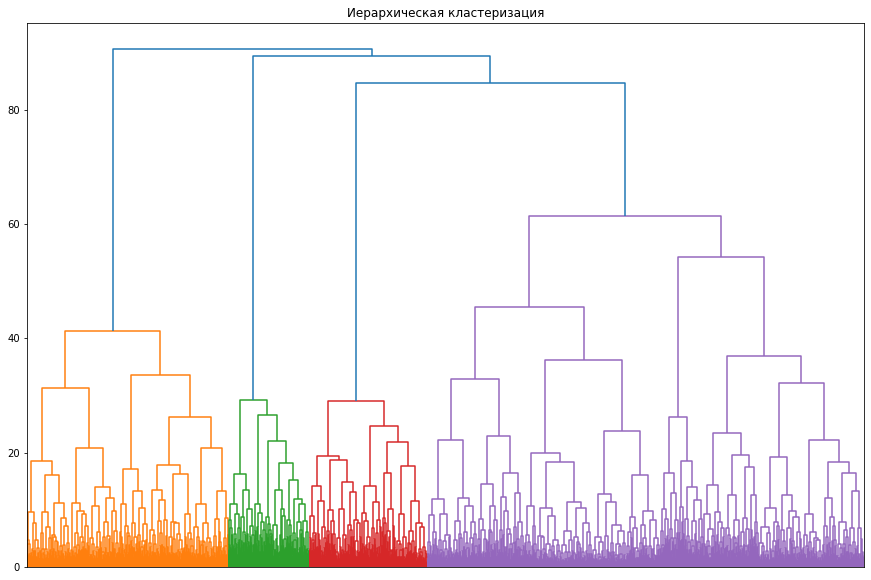

In [21]:
linked = linkage(x_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Иерархическая кластеризация')
plt.show() 

По полученной дендрограмме можно выделить 4 кластера  — четыре разных цвета на графике.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Договоримся за число кластеров принять n=4, согласно распределению на дендограмме.

In [26]:
# задаём модель k_means с числом кластеров 4 и фиксируем значение random_state
km = KMeans(n_clusters=4, random_state=0) 
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 3)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
data['cluster'] = labels

# выводим статистику по средним значениям наших признаков по кластеру, отсортировав по значению Churn
round(data.groupby('cluster').mean().sort_values(by='Churn'),3)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,
2,0.527,0.922,0.370,0.004,1.0,5.894,0.536,30.572,173.536,5.134,2.254,0.032
3,0.504,0.967,0.868,1.000,1.0,6.638,0.517,29.544,151.932,4.246,1.902,0.129
0,0.523,0.863,0.472,0.306,0.0,4.777,0.427,29.298,144.208,3.940,1.724,0.267
1,0.495,0.671,0.297,0.044,1.0,1.946,0.208,27.555,118.680,1.917,1.213,0.593


Выше мы вывели средние значения признаков для кластеров, отсортировав по возрастанию среднего значения Churn. Т.е в верхней строке кластер клиентов "в среднем менее склонных к оттоку", а в нижней - "в среднем более склонных к оттоку". Можем заметить, что почти по всем небинарным признакам наблюдается тенденция уменьшения значения сверху-вниз. 

Таким образом, клиенты в кластере более склонных к оттоку - в среднем реже посещают зал за неделю, меньше тратят на дополнительные услуги. Их средний lifetime в клубе короче, а средняя длительность абонементов - меньше. Еще, как ни странно, они в среднем моложе.

Визуализируем распределения признаков для кластеров с помощью графиков violinplot.

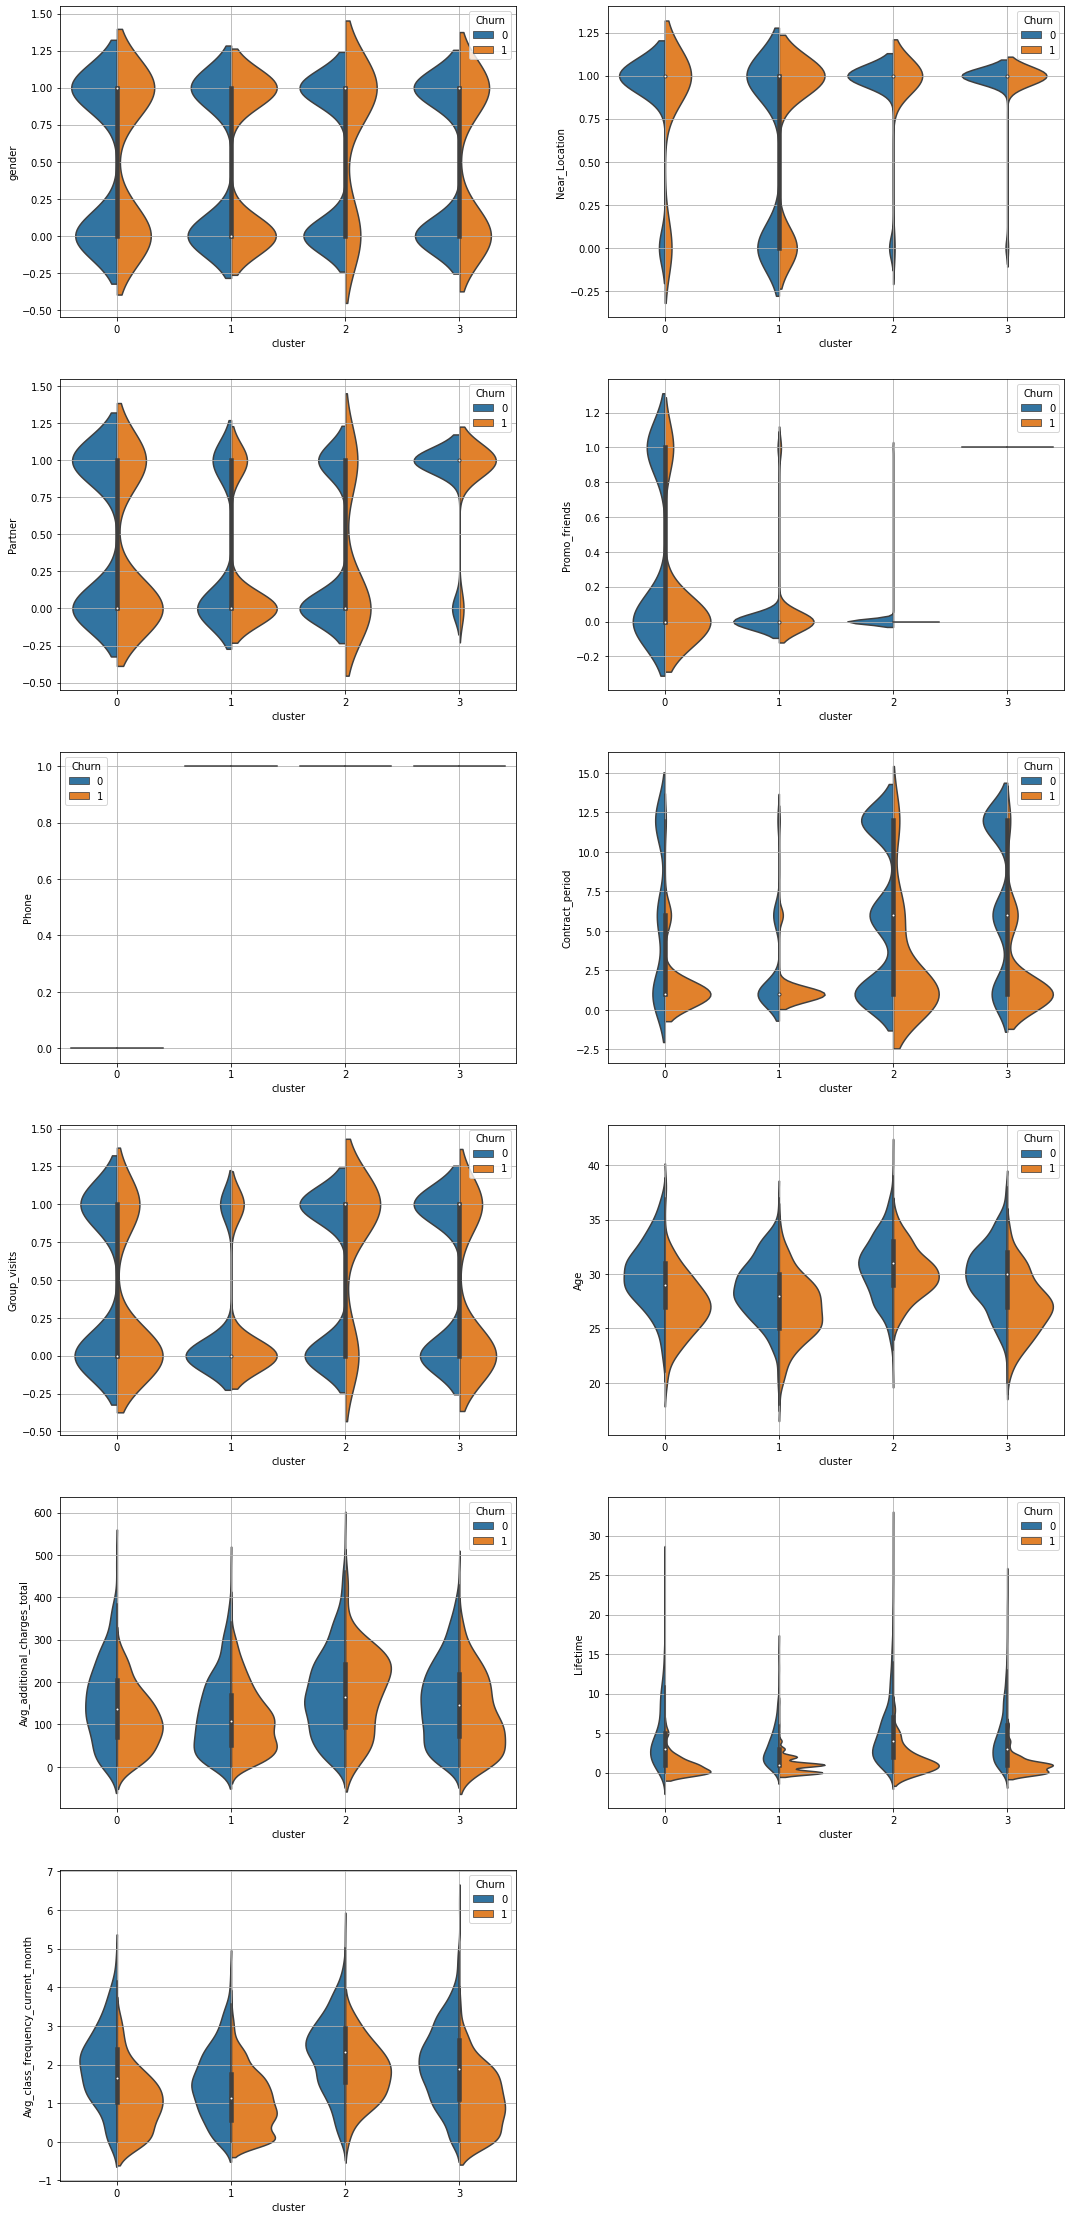

In [27]:
fig = plt.figure(figsize=(18, 40))
i = 0

for col in data.drop(['cluster', 'Churn'], axis=1).columns:
    i+=1
    ax=fig.add_subplot(6,2,i)
    sns.violinplot(x='cluster',
                   y=col,
                   data=data,
                   hue='Churn',
                   split=True,
                   ax=ax
                      ) 
    

    plt.grid()
     
plt.show()        
    
   


Из полученных графиков мы можем заметить следующие интересные закономерности:
   1. Нет существенных "перекосов" по половому признаку ни в одном из кластеров - мужчины и женщины остаются активными или "оттекают" одинаково.
   2. Похожая картина наблюдается в распределении по признаку сотрудника компании-партнера: партнеры и непартнеры оттекают "симметрично". 
   3. Во всех кластерах чаще перестают ходить в фитнес-клуб клиенты с маленьким сроком абонемента (1 месяц).
   4. Чем моложе клиенты - тем они больше склонны к оттоку 
   5. Клиенты, которые недавно начали посещать фитнес-клуб - чаще перестают в него ходить. (Довольно очевидный факт, но на графике он подтверждается )
   6. "Оттекающие" клиенты имеют меньшую недельную частоту посещений, чем активные.
    
       
       

Для каждого полученного кластера посчитаем долю оттока (методом groupby()). 

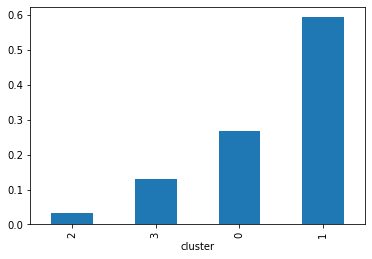

In [28]:
data.groupby('cluster')['Churn'].mean().sort_values().plot(kind='bar')
plt.show()

Как мы отмечали ранее - доля оттока разная во всех кластерах. Кластеры 1 и 0 - более склонны к оттоку, а кластеры 2 и 3 - более надежны.

## Выводы и рекомендации

Мы провели исследование данных месячной активности клиентов, и выявили, что активных клиентов значительно больше, чем склонных к оттоку. При этом к оттоку более склонны люди, которые недавно начали посещать фитнес-клуб (меньше 2 месяцев),взяли абонемент на короткий срок (1 месяц) или редко ходят(менее 2 раз в неделю). В то же время, молодые люди (до 25 лет) чаще бросают заниматься спортом. Исходя из полученных наблюдений, можем предположить, что повысить удержание клиентов можно следующим образом:
1. Привлекать людей более зрелого возраста
2. Увеличить минимальный срок абонемента - возможно, мотивация клиентов вырастет, если они потратят на абонемент больше денег
3. Внедрить персональную систему поощрений для ленивых клиентов за более частые посещения (например, сходил 3 раза в неделю- 4й бесплатно). Для всех клиентов такую акцию проводить не выгодно - многие итак хорошо ходят, но для некоторых могло бы быть эффективно

